Code based on https://www.datascience.com/blog/fraud-detection-with-tensorflow

Download data from https://www.kaggle.com/mlg-ulb/creditcardfraud/downloads/creditcardfraud.zip/3

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
import time

import keras
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

In [32]:
df = pd.read_csv("data/creditcard.csv") 
print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
# Drop label column
y = df['Class']
X = df.drop('Class', axis=1)

In [14]:
# Normalize time and amount (all other fields are result of PCA and so are normalized)
X_norm = X
X['Time'] = StandardScaler().fit_transform(X['Time'].values.reshape(-1, 1))
X['Amount'] = StandardScaler().fit_transform(X['Amount'].values.reshape(-1, 1))

## Isolation Forest

In [18]:
# Run isolation Forest
from sklearn.ensemble import IsolationForest

start = time.time()
if_model = IsolationForest(behaviour = 'new', max_samples=100, 
                      random_state = 1, contamination = 'auto')
if_model.fit(X)
anomaly_scores = if_model.decision_function(X)
end = time.time()

print('Run time: %.4f sec' %(end-start))

Run time: 26.8826 sec


In [31]:
# Show results
thresh = 0.01 # given that the model was run with contamination = 'auto', a score 
              # of 0 is corresponds to above 20% of scores. 
              # This affects the sensitivity and specificity but not the main AUC result. 

out_pred = (anomaly_scores<thresh).astype('int')

sensitivity = np.sum(np.logical_and(y==1,out_pred==1))/np.sum(y==1)
specificity = np.sum(np.logical_and(y==0,out_pred==0))/np.sum(y==0)
auc = sk.metrics.roc_auc_score(y,-anomaly_scores)

print('Detected %d (of %d) anomalies' %(np.sum(out_pred), np.sum(y)))
print('AUC = \t\t%f \nsensitivity = \t%.3f \nspecificity = \t%.3f' %(auc, sensitivity, specificity))

Detected 25976 (of 492) anomalies
AUC = 		0.948454 
sensitivity = 	0.884 
specificity = 	0.910


#### AUC of 0.948 is not bad

## Autoencoder on IF-labled data

The autoencoder is unsupervised but assumes that the training data does not include anomalies. 
Given that we don't know the labels, let's assume that if we use a high enough threshold, we will be left with none or very few outlier samples

In [72]:
my_thres = 0.01
my_y = anomaly_scores < my_thres

X_train = X.iloc[my_y==False]
X_train.shape

(258831, 30)

Now train an autoencode on this more-or-less non-anomalous data

In [73]:
X_train, X_test = train_test_split(X_train, test_size=0.1, random_state=1)
X_train = X_train.values #transform to ndarray
X_test = X_test.values

In [75]:
nb_epoch = 100
batch_size = 128
input_dim = X_train.shape[1] #num of columns, 30
encoding_dim = 14
hidden_dim = int(encoding_dim / 2) #i.e. 7
learning_rate = 1e-7

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)


In [76]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

cp = ModelCheckpoint(filepath="autoencoder_fraud.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[cp, tb]).history

W0904 12:22:30.958676  8536 deprecation_wrapper.py:119] From C:\Users\Edden\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0904 12:22:31.109590  8536 deprecation_wrapper.py:119] From C:\Users\Edden\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:1020: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 232947 samples, validate on 25884 samples


W0904 12:22:31.494969  8536 deprecation_wrapper.py:119] From C:\Users\Edden\Anaconda3\lib\site-packages\keras\callbacks.py:1122: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W0904 12:22:31.496967  8536 deprecation_wrapper.py:119] From C:\Users\Edden\Anaconda3\lib\site-packages\keras\callbacks.py:1125: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/100
232947/232947 [==============================] - 4s 16us/step - loss: 0.5111 - acc: 0.5243 - val_loss: 0.4583 - val_acc: 0.6210
Epoch 2/100
232947/232947 [==============================] - 3s 15us/step - loss: 0.4471 - acc: 0.6429 - val_loss: 0.4355 - val_acc: 0.6576
Epoch 3/100
232947/232947 [==============================] - 4s 19us/step - loss: 0.4347 - acc: 0.6631 - val_loss: 0.4289 - val_acc: 0.6672
Epoch 4/100
232947/232947 [==============================] - 5s 21us/step - loss: 0.4304 - acc: 0.6738 - val_loss: 0.4263 - val_acc: 0.6755
Epoch 5/100
232947/232947 [==============================] - 4s 19us/step - loss: 0.4283 - acc: 0.6841 - val_loss: 0.4250 - val_acc: 0.6873
Epoch 6/100
232947/232947 [==============================] - 5s 22us/step - loss: 0.4271 - acc: 0.6912 - val_loss: 0.4240 - val_acc: 0.6928
Epoch 7/100
232947/232947 [==============================] - 6s 25us/step - loss: 0.4264 - acc: 0.6953 - val_loss: 0.4235 - val_acc: 0.6941
Epoch 8/100
232947/2

232947/232947 [==============================] - 4s 18us/step - loss: 0.4195 - acc: 0.7201 - val_loss: 0.4166 - val_acc: 0.7211
Epoch 60/100
232947/232947 [==============================] - 4s 18us/step - loss: 0.4194 - acc: 0.7207 - val_loss: 0.4168 - val_acc: 0.7185
Epoch 61/100
232947/232947 [==============================] - 5s 22us/step - loss: 0.4194 - acc: 0.7207 - val_loss: 0.4165 - val_acc: 0.7201
Epoch 62/100
232947/232947 [==============================] - 5s 21us/step - loss: 0.4194 - acc: 0.7206 - val_loss: 0.4166 - val_acc: 0.7221
Epoch 63/100
232947/232947 [==============================] - 5s 23us/step - loss: 0.4194 - acc: 0.7205 - val_loss: 0.4164 - val_acc: 0.7226
Epoch 64/100
232947/232947 [==============================] - 5s 21us/step - loss: 0.4194 - acc: 0.7206 - val_loss: 0.4165 - val_acc: 0.7222
Epoch 65/100
232947/232947 [==============================] - 4s 19us/step - loss: 0.4193 - acc: 0.7210 - val_loss: 0.4166 - val_acc: 0.7212
Epoch 66/100
232947/232947

In [ ]:
# Load saved model
autoencoder = load_model('autoencoder_fraud.h5')

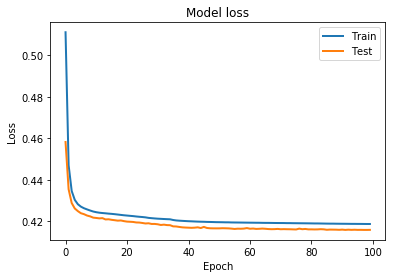

In [77]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

Now run the trained model on our entire dataset

In [78]:
X_full_predictions = autoencoder.predict(X)
mse = np.mean(np.power(X - X_full_predictions, 2), axis=1)

<function matplotlib.pyplot.show(*args, **kw)>

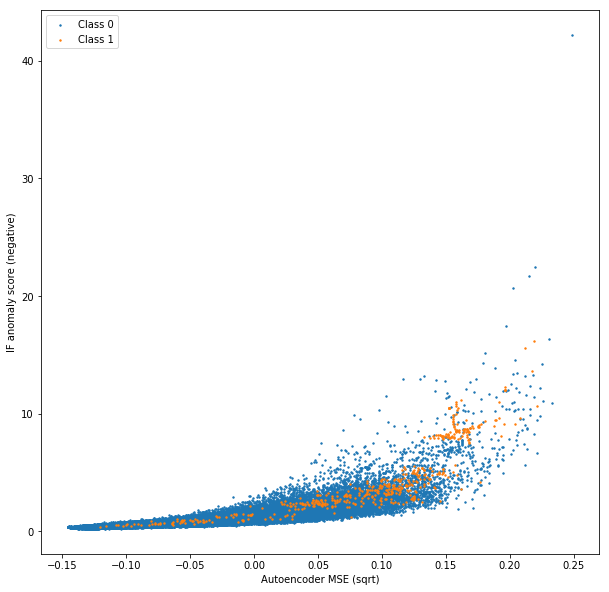

In [102]:
plt.figure(figsize=[10,10])
plt.scatter(-anomaly_scores[y==0], np.sqrt(mse[y==0]),s=2, label='Class 0')
plt.scatter(-anomaly_scores[y==1], np.sqrt(mse[y==1]),s=2, label='Class 1')
plt.ylabel('IF anomaly score (negative)')
plt.xlabel('Autoencoder MSE (sqrt)')
plt.legend()
plt.show

In [99]:
# Show results
thresh = 5 # This affects the sensitivity and specificity but not the main AUC result
out_pred = (mse>thresh).astype('int')

sensitivity = np.sum(np.logical_and(y==1,out_pred==1))/np.sum(y==1)
specificity = np.sum(np.logical_and(y==0,out_pred==0))/np.sum(y==0)
auc = sk.metrics.roc_auc_score(y,mse)

print('Detected %d (of %d) anomalies' %(np.sum(out_pred), np.sum(y)))
print('AUC = \t\t%f \nsensitivity = \t%.3f \nspecificity = \t%.3f' %(auc, sensitivity, specificity))

Detected 4446 (of 492) anomalies
AUC = 		0.954355 
sensitivity = 	0.789 
specificity = 	0.986


####  AUC improved from 0.948 to 0.954. 
This is even better than the AUC=0.933 result from the original demonstration using only autoencoder (but with known labels)

### Explaining the results:

A non-anomalous sample:

(-0.1, 2)

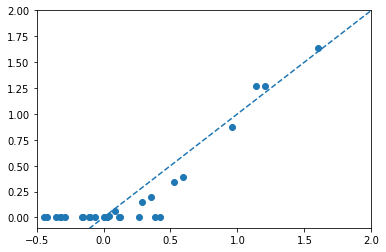

In [153]:
i = 130156
plt.scatter(X.values[i], X_full_predictions[i])
plt.plot([-10, 10], [-10, 10], linestyle='--')
plt.xlim(-0.5,2)
plt.ylim(-0.1,2)

An anomalous sample:

(-1, 25)

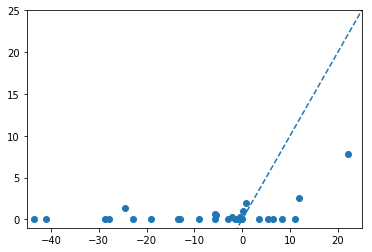

In [157]:
i = 154684
plt.scatter(X.values[i], X_full_predictions[i])
plt.plot([-50, 50], [-50, 50], linestyle='--')
plt.xlim(-45, 25)
plt.ylim(-1, 25)

Sort features by model error:

In [170]:
error_by_column = (X_full_predictions[i] - X.iloc[i].values)**2
error_df = pd.DataFrame()
error_df['Feature'] = X.columns
error_df['Predicted value'] = X_full_predictions[i]
error_df['Actual value'] = X.iloc[i].values
error_df['Error'] = error_by_column
error_df.sort_values('Error', ascending=False)

,Feature,Predicted value,Actual value,Error
7,V7,0.000000,-43.557242,1897.233293
8,V8,0.000000,-41.044261,1684.631355
1,V1,0.000000,-28.709229,824.219844
3,V3,0.000000,-27.855811,775.946214
10,V10,1.337822,-24.588262,672.161834
21,V21,0.000000,-22.797604,519.730744
5,V5,0.000000,-18.983813,360.385140
2,V2,7.848859,22.057729,201.891978
9,V9,0.000000,-13.320155,177.426521
17,V17,0.062364,-13.032785,171.482925
